# Part 2, XGBoost

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split  # 注意修改的地方
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBRegressor

# 更新sklearn废弃语法其他代码保持不变

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

这部分主要内容就是Xgboost啦

## 数据预处理

In [2]:
train = pd.read_csv('../train.csv')

做对数转换

In [3]:
train['log_loss'] = np.log(train['loss'])

数据分成连续和离散特征

In [4]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 116
Numerical features: 14


And use a label encoder for categorical features:

In [5]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


## Simple XGBoost Model

首先，我们训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差来衡量

mean_absolute_error(np.exp(y), np.exp(yhat))。


xgboost 自定义了一个数据矩阵类 DMatrix，会在训练开始时进行一遍预处理，从而提高之后每次迭代的效率

In [6]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

### Model

In [7]:
dtrain = xgb.DMatrix(train_x, train['log_loss'])

## Xgboost参数
- 'booster':'gbtree',
- 'objective': 'multi:softmax', 多分类的问题
- 'num_class':10, 类别数，与 multisoftmax 并用
- 'gamma':0.1,  用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
- 'max_depth':12, 构建树的深度，越大越容易过拟合
- 'lambda':2,  控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
- 'subsample':0.7, 随机采样训练样本
- 'colsample_bytree':0.7, 生成树时进行的列采样
- 'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
- 'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
- 'eta': 0.007, 如同学习率
- 'seed':1000,
- 'nthread':7, cpu 线程数

In [8]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

使用交叉验证 `xgb.cv` 

In [9]:
%%time


        

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1206.709717
CPU times: total: 37.8 s
Wall time: 4.49 s


我们得到了第一个基准结果：MAE＝1218.9

<Axes: >

<Figure size 640x480 with 0 Axes>

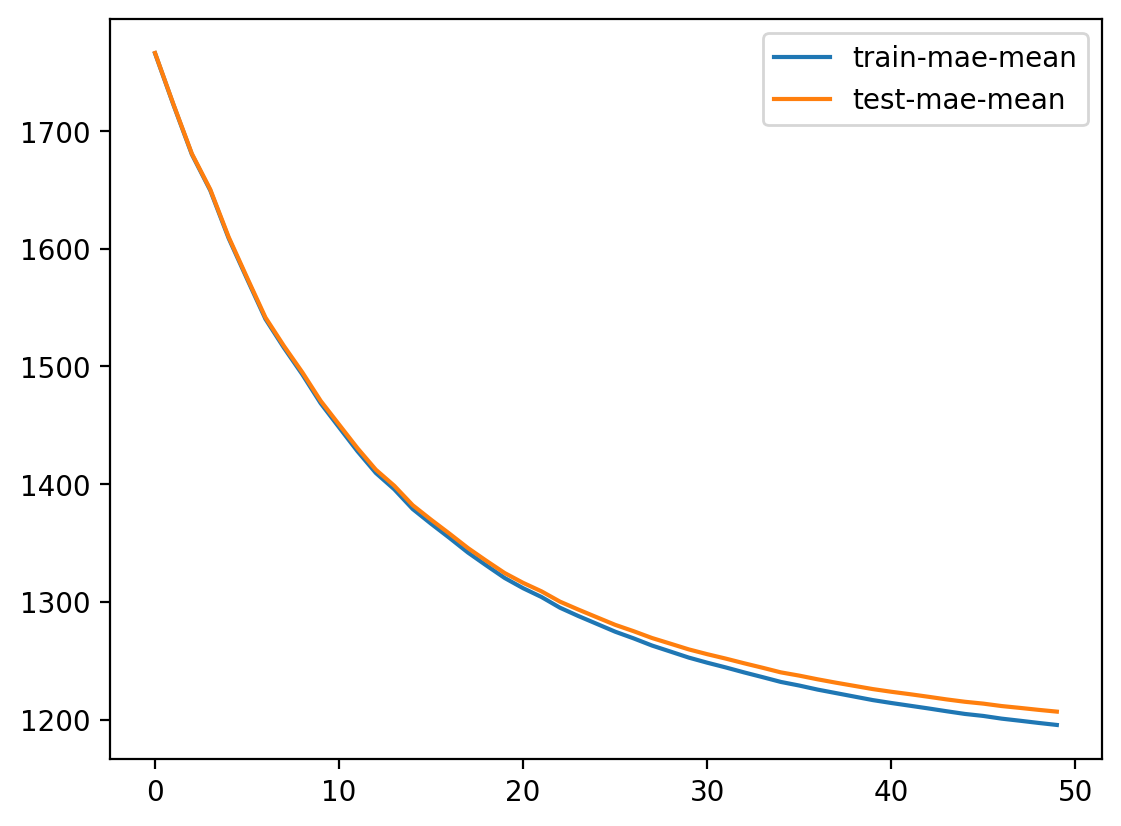

In [10]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

### 我们的第一个基础模型：

* 没有发生过拟合
* 只建立了50个树模型


In [11]:
%%time
#建立100个树模型
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 1172.4772540000001
CPU times: total: 1min 3s
Wall time: 6.88 s


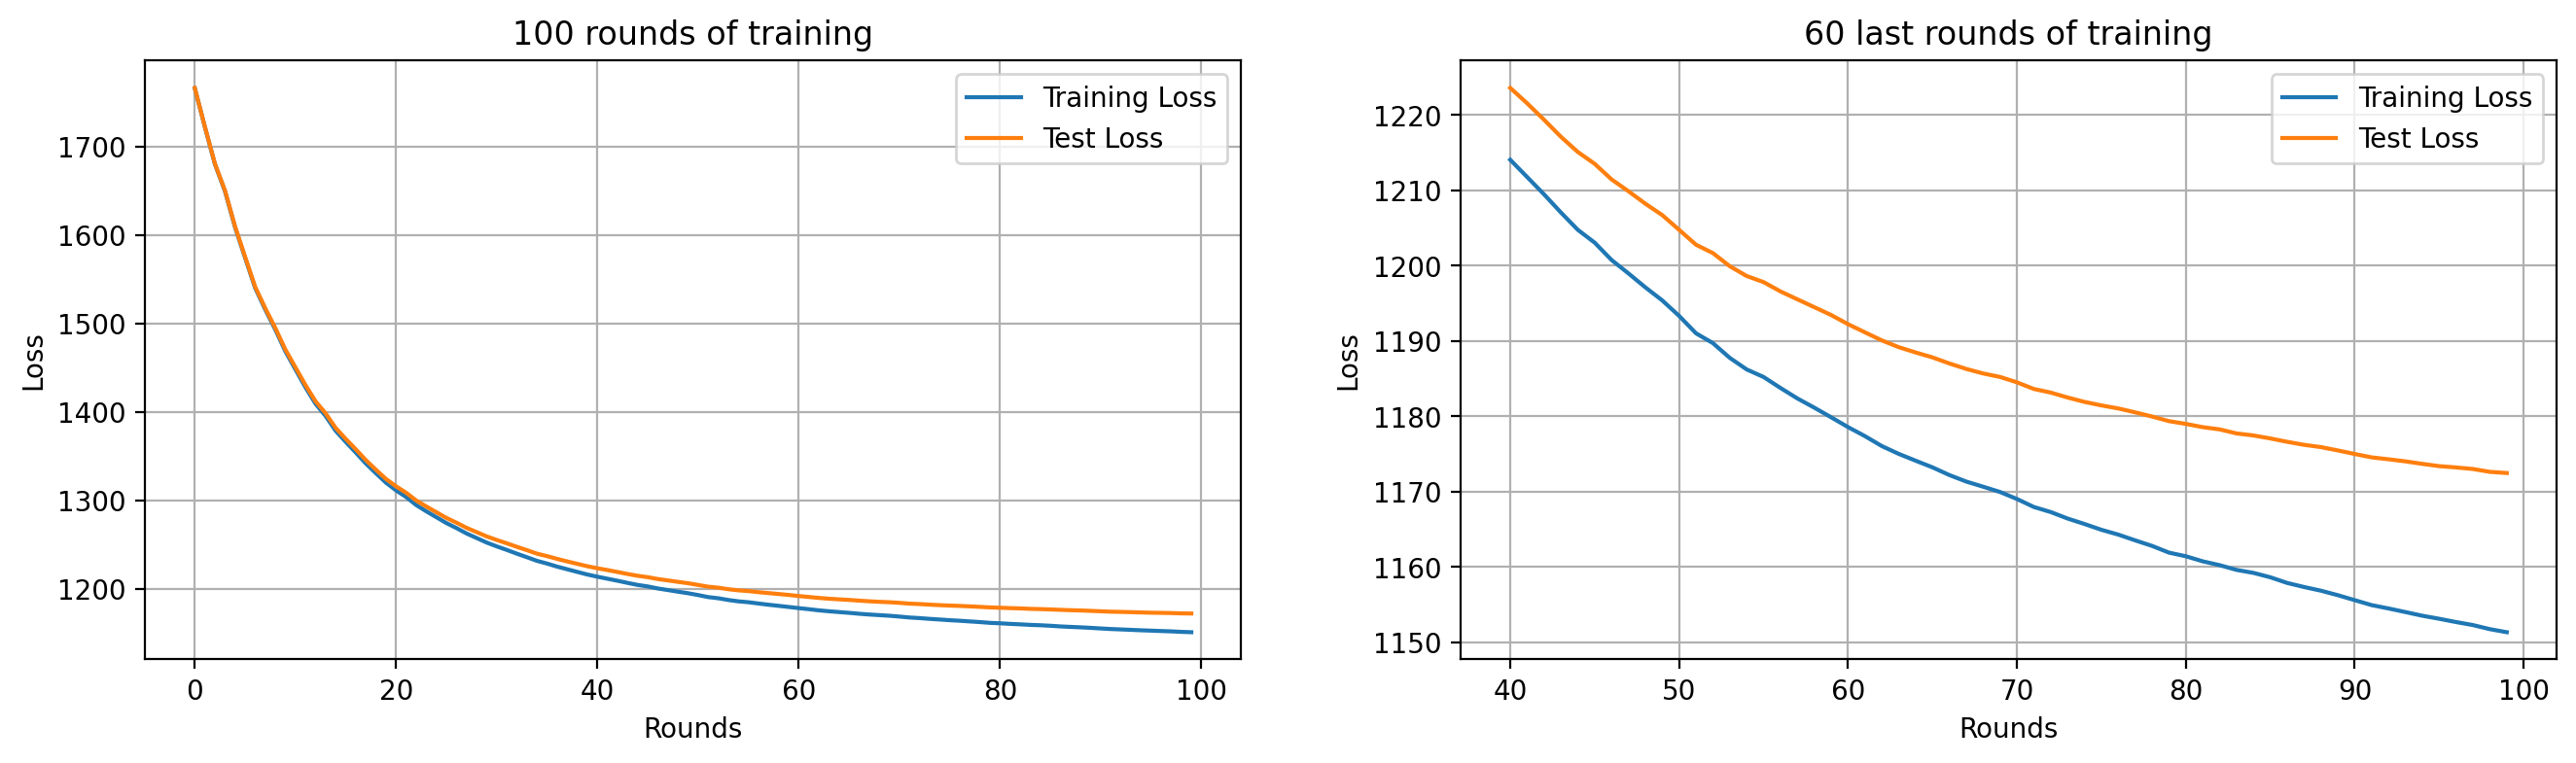

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

有那么一丁丁过拟合，现在还没多大事

我们得到了新的纪录 **MAE = 1171.77** 比第一次的要好 (1218.9). 接下来我们要改变其他参数了。

## XGBoost 参数调节

* Step 1: 选择一组初始参数


* Step 2: 改变 `max_depth` 和 `min_child_weight`.


* Step 3: 调节 `gamma` 降低模型过拟合风险.


* Step 4: 调节 `subsample` 和 `colsample_bytree` 改变数据采样策略.


* Step 5: 调节学习率 `eta`.

In [13]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [14]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [15]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

In [16]:
bst.kfold(train_x, train_y, nfold=5)

train-rmse-mean       0.557488
train-rmse-std        0.000295
test-rmse-mean        0.561397
test-rmse-std         0.002787
train-mae-mean     1196.030957
train-mae-std         1.777483
test-mae-mean      1206.267163
test-mae-std          9.164919
Name: 49, dtype: float64

### Step 1: 学习率与树个数

### Step 2: 树的深度与节点权重

这些参数对xgboost性能影响最大，因此，他们应该调整第一。我们简要地概述它们：


* `max_depth`: 树的最大深度。增加这个值会使模型更加复杂，也容易出现过拟合，深度3-10是合理的。

* `min_child_weight`: 正则化参数. 如果树分区中的实例权重小于定义的总和，则停止树构建过程。

In [17]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [18]:
%%time
 
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: total: 17min
Wall time: 1min 39s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x0000015C0A936500>,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 6]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [19]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([0.95418625, 1.06630015, 1.04280629, 1.08104968, 1.12349806,
         1.08202214, 1.29513335, 1.2104979 , 1.29725323, 1.2968235 ,
         1.28910294, 1.24078989, 1.33198891, 1.31750979, 1.37958503]),
  'std_fit_time': array([0.02560475, 0.09953494, 0.14718764, 0.08874489, 0.04862411,
         0.03485897, 0.05424966, 0.03313408, 0.03675597, 0.01587935,
         0.05857077, 0.08899486, 0.06559139, 0.0603898 , 0.1747308 ]),
  'mean_score_time': array([0.08673921, 0.08677192, 0.08367114, 0.0987155 , 0.09241858,
         0.0939311 , 0.10987587, 0.09404826, 0.10066733, 0.10267987,
         0.10198393, 0.09482036, 0.0931859 , 0.09182076, 0.10296931]),
  'std_score_time': array([0.00790823, 0.00870385, 0.00792893, 0.006299  , 0.01247466,
         0.00793956, 0.01185096, 0.0050396 , 0.00356678, 0.00816842,
         0.00672205, 0.00519271, 0.00639421, 0.00854339, 0.01238673]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8],
        

网格搜索发现的最佳结果:

`{'max_depth': 8, 'min_child_weight': 6},
 -1187.9597499123447)`
 
设置成负的值是因为要找大的值


In [20]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in range(len(scores['params'])):
        _params.append(list(scores['params'][i].values()))
        _params_mae.append(scores['mean_test_score'][i])
    params = np.array(_params)
    grid_res = np.column_stack((_params, _params_mae))
    return [grid_res[:, i] for i in range(grid_res.shape[1])]

In [21]:
O,o,scores =  convert_grid_scores(grid.cv_results_)
scores = scores.reshape(5,3)
print(O,o,scores)


[4. 4. 4. 5. 5. 5. 6. 6. 6. 7. 7. 7. 8. 8. 8.] [1. 3. 6. 1. 3. 6. 1. 3. 6. 1. 3. 6. 1. 3. 6.] [[-1230.17247133 -1230.10268855 -1229.69817259]
 [-1205.396058   -1205.6024402  -1205.40425092]
 [-1190.44236922 -1190.36466289 -1189.46700708]
 [-1180.88278445 -1180.70923764 -1180.62251818]
 [-1175.93761281 -1175.04221124 -1174.97195103]]


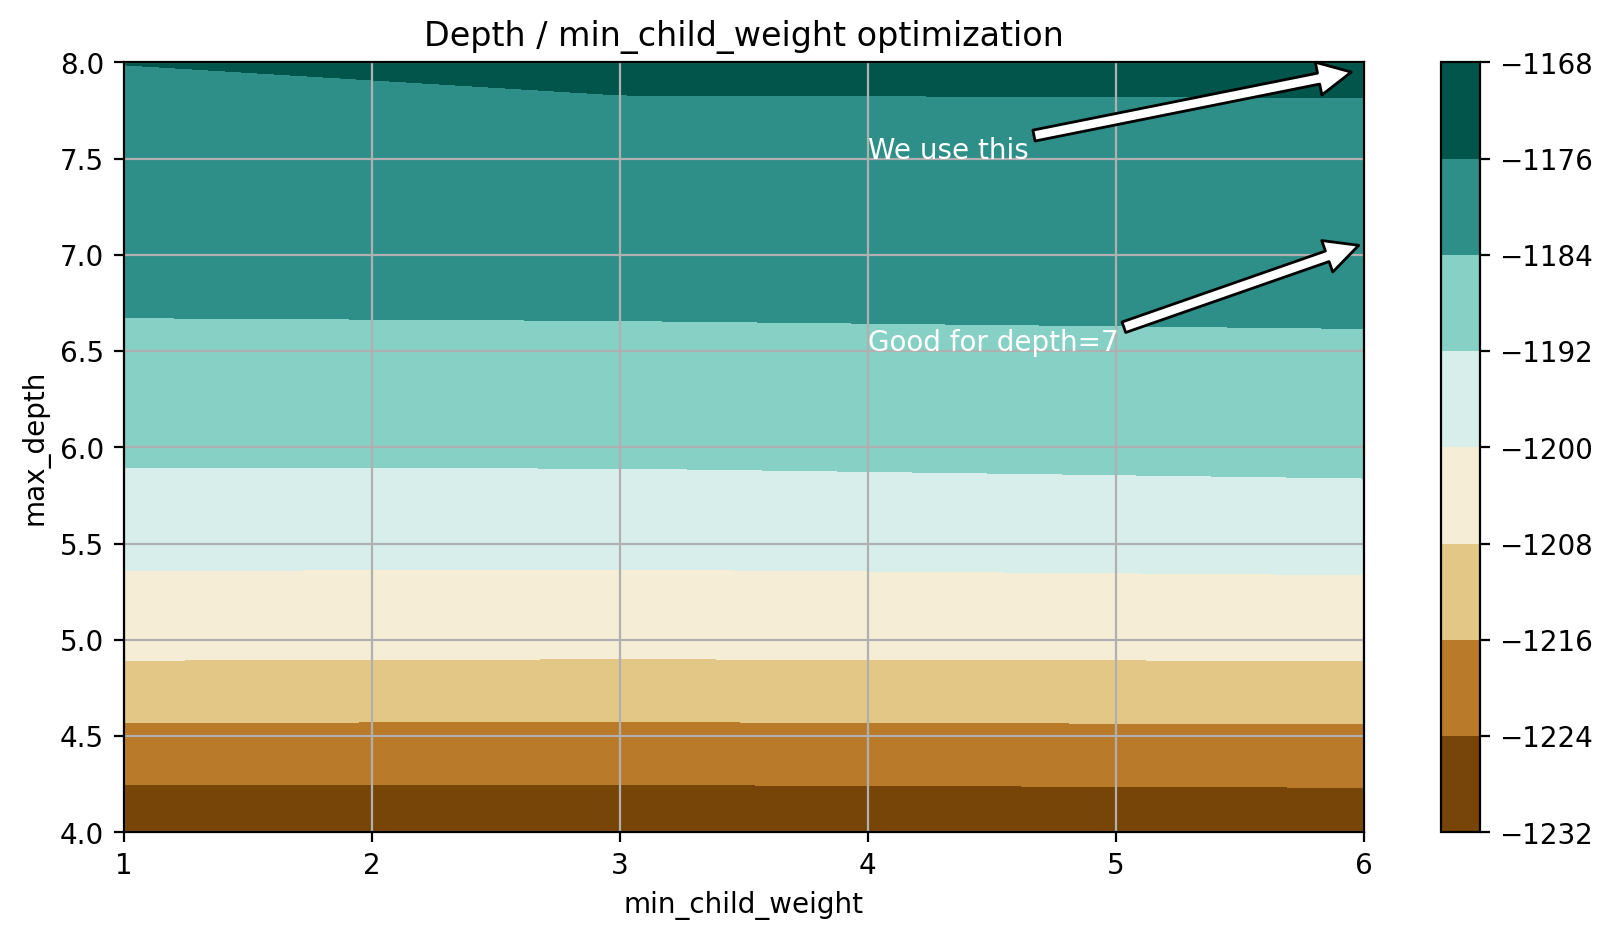

In [22]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

我们看到，从网格搜索的结果，分数的提高主要是基于max_depth增加.
min_child_weight稍有影响的成绩，但是，我们看到，min_child_weight = 6会更好一些。

### Step 3: 调节 gamma去降低过拟合风险

In [23]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: total: 6min 23s
Wall time: 43.1 s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x0000015C0A935630>,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [24]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([1.9405036 , 1.59583058, 1.51356535, 1.41588974, 1.31448574]),
  'std_fit_time': array([0.45837974, 0.08066484, 0.06266585, 0.11405891, 0.05749157]),
  'mean_score_time': array([0.12320848, 0.10403156, 0.10134969, 0.09945498, 0.09158134]),
  'std_score_time': array([0.00719573, 0.00931602, 0.00844149, 0.00951811, 0.00780553]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.30000000000000004},
   {'gamma': 0.4}],
  'split0_test_score': array([-1175.78859251, -1176.44814143, -1175.60290538, -1175.89256183,
         -1175.83591049]),
  'split1_test_score': array([-1172.20460489, -1172.21666028, -1172.38943632, -1171.78740546,
         -1171.70604485]),
  'split2_test_score': array([-1185.20171965, -1184.0696329 , -1184.48763459, -1183.73351969,

我们选择使用偏小一些的 `gamma`.

### Step 4: 调节样本采样方式 subsample 和 colsample_bytree

In [25]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

CPU times: total: 11min 58s
Wall time: 1min 7s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x0000015C0AB54AC0>,
             param_grid={'colsample_bytree': [0.6000000000000001,
                                              0.7000000000000001, 0.8],
                         'subsample': [0.6000000000000001, 0.7000000000000001,
                                       0.8]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [26]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([1.36614218, 1.32922773, 1.29865437, 1.34069681, 1.36310735,
         1.33548436, 1.42104173, 1.42911277, 1.33828197]),
  'std_fit_time': array([0.07606021, 0.03729221, 0.01529763, 0.04589543, 0.04536182,
         0.05362535, 0.07367864, 0.05765473, 0.02669746]),
  'mean_score_time': array([0.09962239, 0.09453578, 0.09025373, 0.09209251, 0.10375695,
         0.0918529 , 0.09150391, 0.09242086, 0.09671865]),
  'std_score_time': array([0.00492439, 0.00971436, 0.01017183, 0.00801084, 0.0102223 ,
         0.00791313, 0.00686592, 0.00634516, 0.01067028]),
  'param_colsample_bytree': masked_array(data=[0.6000000000000001, 0.6000000000000001,
                     0.6000000000000001, 0.7000000000000001,
                     0.7000000000000001, 0.7000000000000001, 0.8, 0.8, 0.8],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array

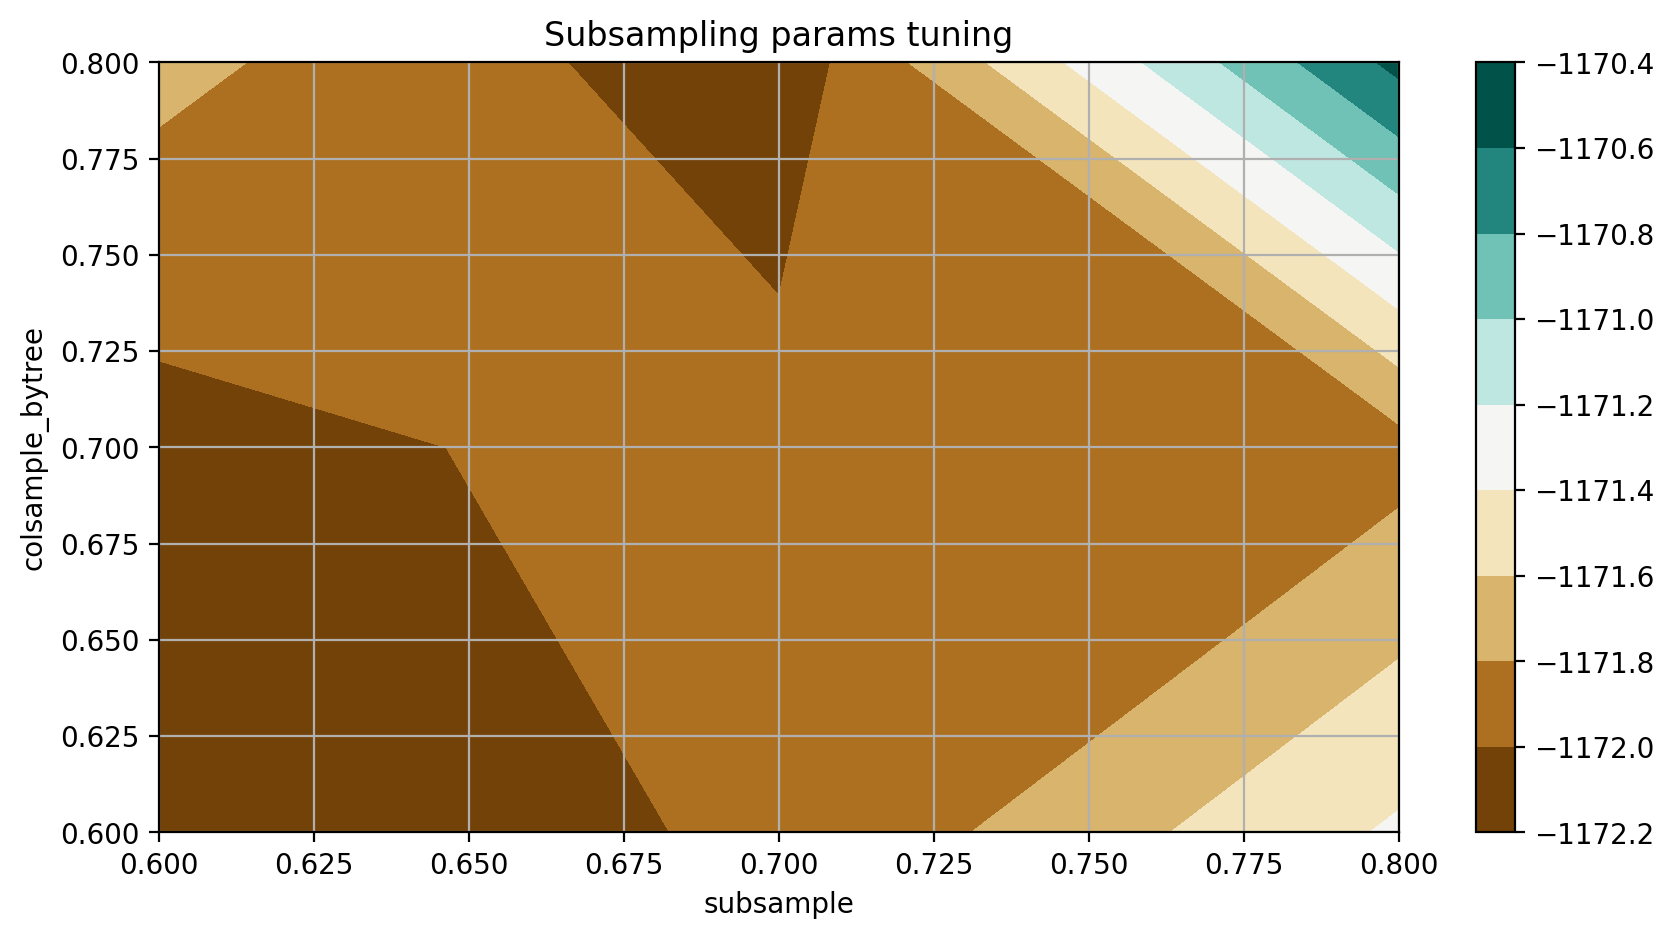

In [27]:
O,o, scores =  convert_grid_scores(grid.cv_results_)
scores = scores.reshape(3,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

在当前的预训练模式的具体案例，我得到了下面的结果：

`{'colsample_bytree': 0.8, 'subsample': 0.8},
 -1182.9309918891634)

### Step 5: 减小学习率并增大树个数

参数优化的最后一步是降低学习速度，同时增加更多的估计量

First, we plot different learning rates for a simpler model (50 trees):

In [28]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: total: 11min 30s
Wall time: 1min 5s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x0000015C0AE06740>,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [29]:
grid.cv_results_

{'mean_fit_time': array([1.15949039, 1.2225389 , 1.28090925, 1.28928638, 1.406672  ,
        1.43251123, 1.34568152, 1.31881499, 1.36902952]),
 'std_fit_time': array([0.03022793, 0.04507748, 0.09739366, 0.05347659, 0.03821216,
        0.07129284, 0.03293753, 0.04681724, 0.04893516]),
 'mean_score_time': array([0.09273272, 0.0906208 , 0.10033493, 0.09733014, 0.09402113,
        0.0972692 , 0.09561439, 0.09219971, 0.1014257 ]),
 'std_score_time': array([0.00855533, 0.00458799, 0.01596507, 0.00743026, 0.00579821,
        0.01243372, 0.01258657, 0.00745798, 0.01008612]),
 'param_eta': masked_array(data=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'eta': 0.5},
  {'eta': 0.4},
  {'eta': 0.3},
  {'eta': 0.2},
  {'eta': 0.1},
  {'eta': 0.075},
  {'eta': 0.05},
  {'eta': 0.04},
  {'eta': 0.03}],
 'split0_test_score': arra

In [30]:
print("Parameter values:", grid.cv_results_['params'])
print(xgb_param_grid)


Parameter values: [{'eta': 0.5}, {'eta': 0.4}, {'eta': 0.3}, {'eta': 0.2}, {'eta': 0.1}, {'eta': 0.075}, {'eta': 0.05}, {'eta': 0.04}, {'eta': 0.03}]
{'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03]}


In [31]:
grid.best_params_, grid.best_score_

({'eta': 0.2}, -1164.3014928544346)

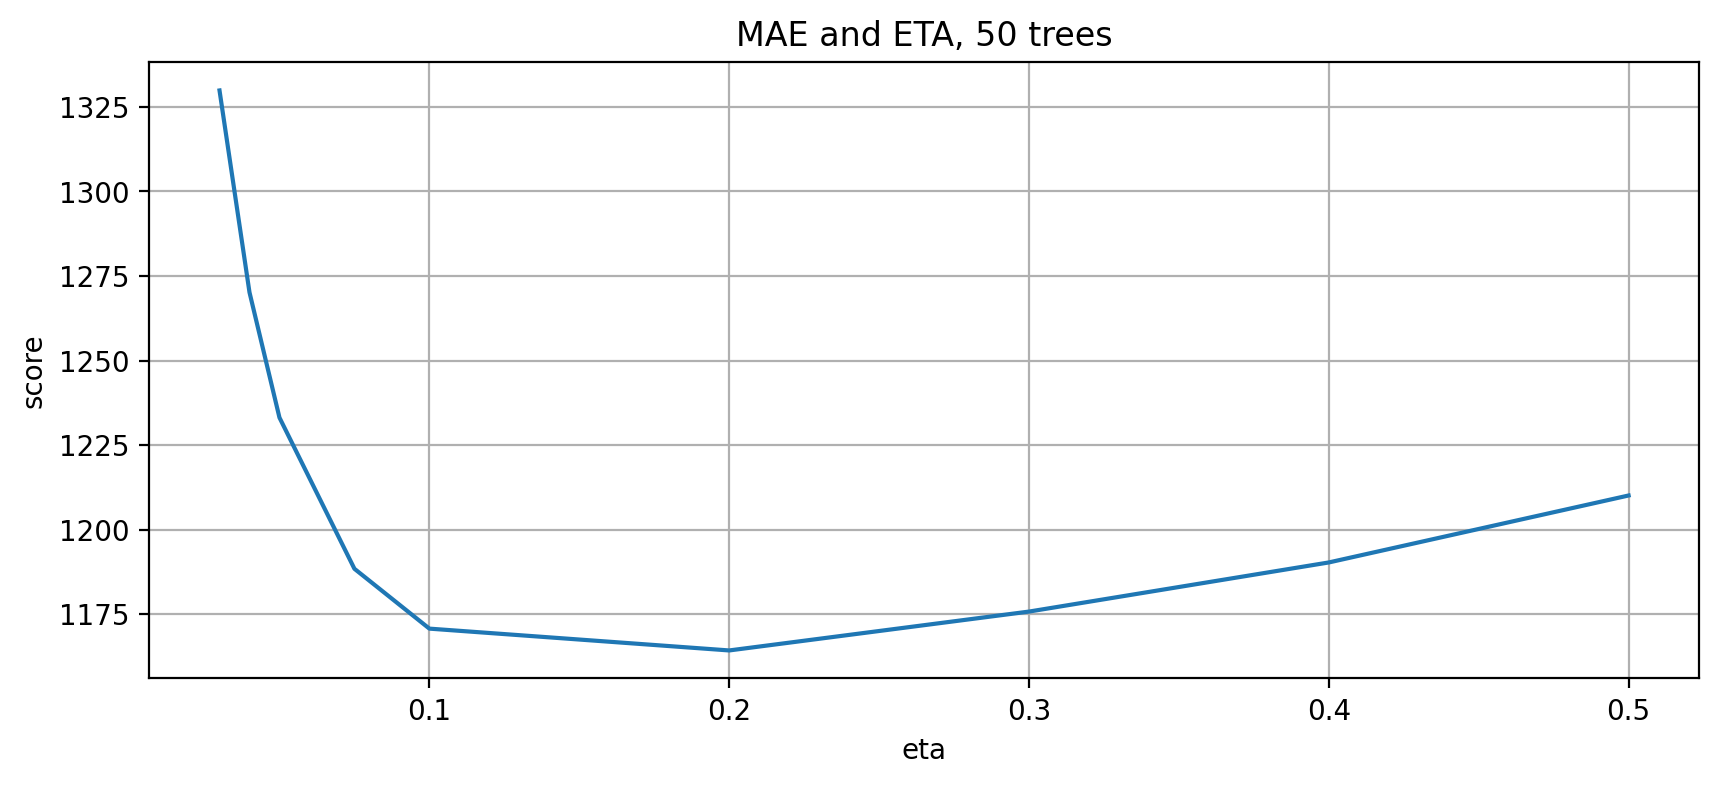

In [34]:
eta, y = convert_grid_scores(grid.cv_results_)
# print(xgb_param_grid)
# eta=[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

`{'eta': 0.2}, -1160.9736284869114` 是目前最好的结果

现在我们把树的个数增加到100

In [35]:

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x0000015C0B33CC40>,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [37]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([1.71882329, 1.65438805, 1.7243824 , 1.69888601, 1.89432731,
         1.95995917, 1.96840301, 1.9803525 , 2.03193617]),
  'std_fit_time': array([0.06267092, 0.03307791, 0.09442014, 0.02501564, 0.01205037,
         0.06460228, 0.01801643, 0.03277023, 0.02297578]),
  'mean_score_time': array([0.09802232, 0.09389696, 0.09831595, 0.09412785, 0.09166031,
         0.09376235, 0.08928351, 0.10556192, 0.0926208 ]),
  'std_score_time': array([0.00953102, 0.00712977, 0.01338216, 0.00675988, 0.00403557,
         0.00511987, 0.00465791, 0.01470129, 0.01172664]),
  'param_eta': masked_array(data=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'eta': 0.5},
   {'eta': 0.4},
   {'eta': 0.3},
   {'eta': 0.2},
   {'eta': 0.1},
   {'eta': 0.075},
   {'eta': 0.05},
   {'eta': 0.04},
   {'eta': 0.03}],
  's

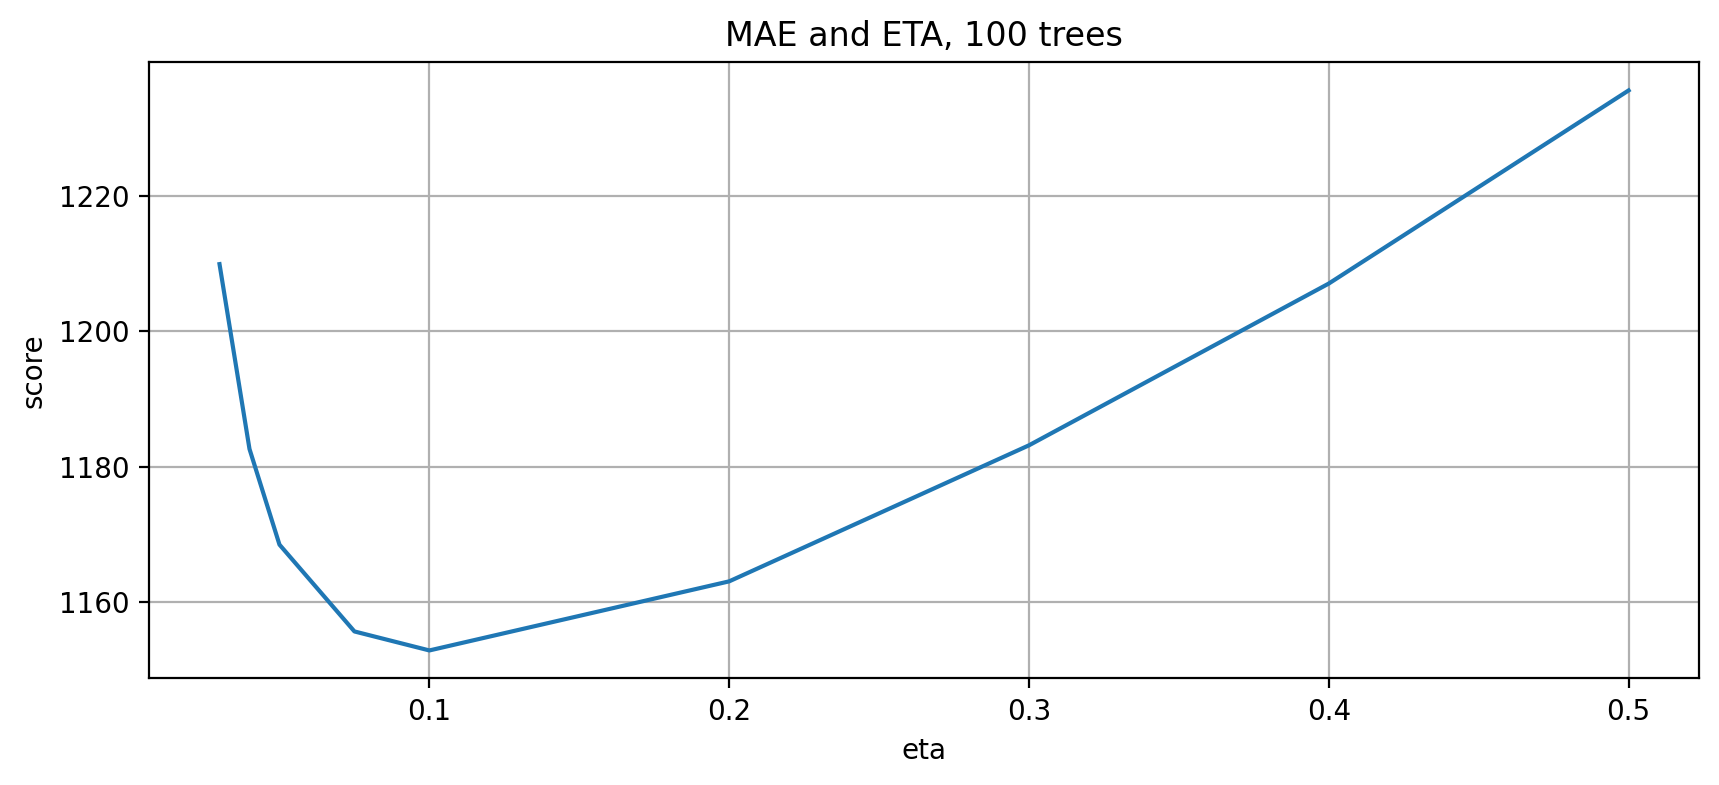

In [38]:
eta, y = convert_grid_scores(grid.cv_results_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

学习率低一些的效果更好

In [39]:
%%time

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: total: 19min 23s
Wall time: 1min 46s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x0000015C0B33E860>,
             param_grid={'eta': [0.09, 0.08, 0.07, 0.06, 0.05, 0.04]},
             scoring=make_scorer(mae_score, greater_is_better=False))

在增加树的个数呢？

In [41]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([3.15869894, 3.2612226 , 3.39605508, 3.24706626, 3.35486164,
         3.43459516]),
  'std_fit_time': array([0.0728709 , 0.12390416, 0.13796451, 0.06922152, 0.04798153,
         0.02760295]),
  'mean_score_time': array([0.11993237, 0.12862911, 0.12581081, 0.12090001, 0.1116591 ,
         0.12124882]),
  'std_score_time': array([0.00482344, 0.02114785, 0.01126458, 0.01206158, 0.00270654,
         0.01401603]),
  'param_eta': masked_array(data=[0.09, 0.08, 0.07, 0.06, 0.05, 0.04],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'eta': 0.09},
   {'eta': 0.08},
   {'eta': 0.07},
   {'eta': 0.06},
   {'eta': 0.05},
   {'eta': 0.04}],
  'split0_test_score': array([-1149.11512981, -1149.09051799, -1148.15118029, -1148.61070258,
         -1148.36028306, -1153.30900114]),
  'split1_test_score': array([-1144.80588324, -1142.35935201, -1144.01737293, -1144.35912904,
         -1145.18008825

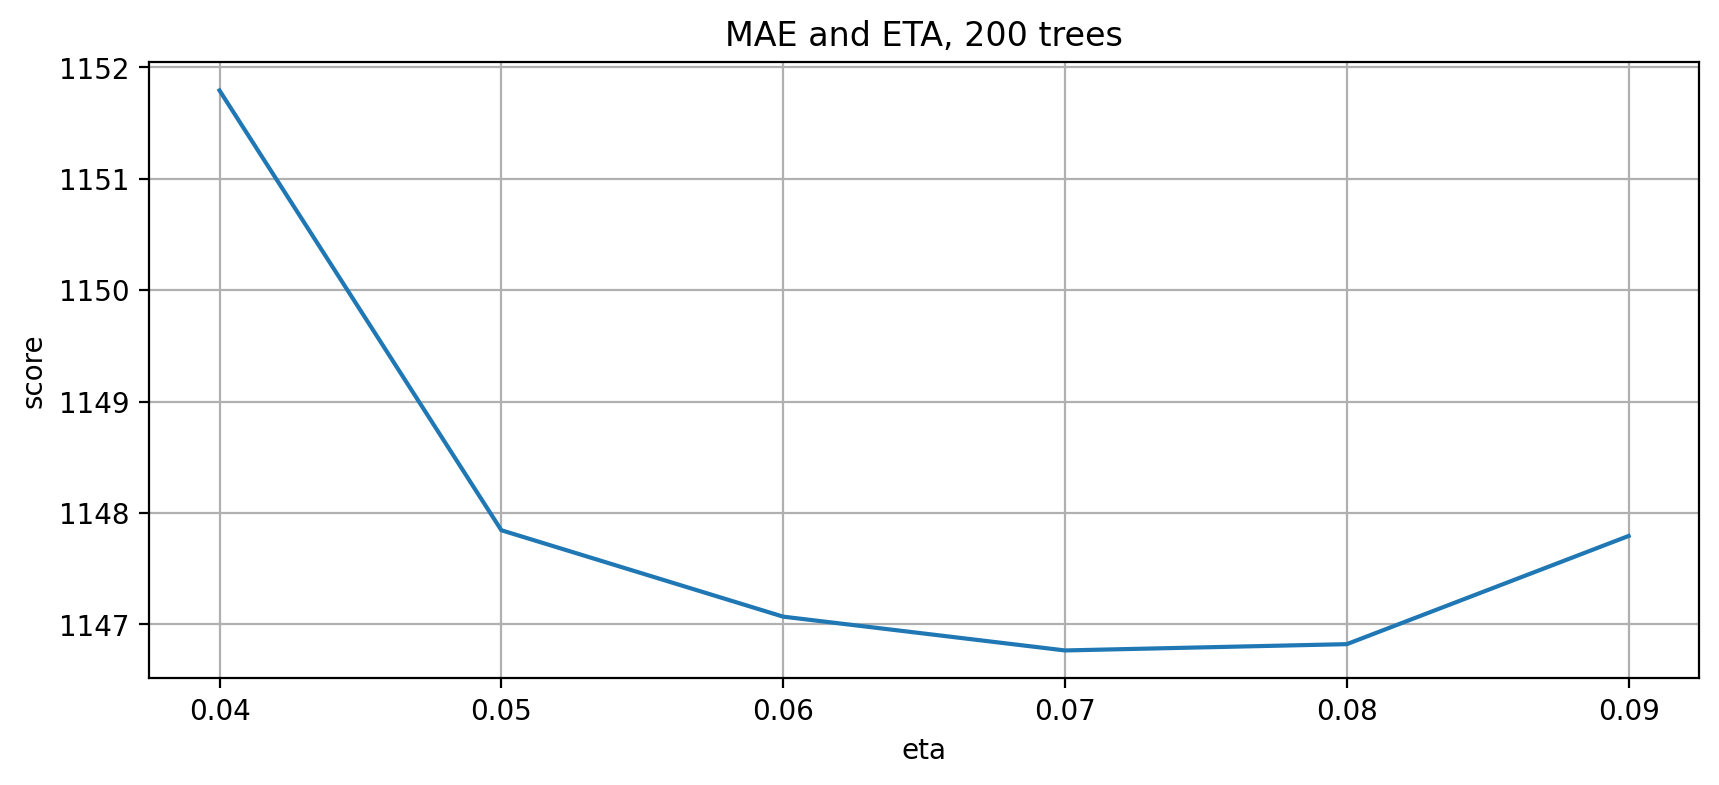

In [43]:
eta, y = convert_grid_scores(grid.cv_results_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [44]:
%%time

# Final XGBoost model


bst = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(train_x, train_y, nfold=5)

CPU times: total: 4min 19s
Wall time: 25.5 s


In [45]:
cv

train-rmse-mean       0.493538
train-rmse-std        0.000466
test-rmse-mean        0.537888
test-rmse-std         0.002342
train-mae-mean     1030.558447
train-mae-std         1.563263
test-mae-mean      1146.222143
test-mae-std          8.555675
Name: 199, dtype: float64

我们看到200棵树最好的ETA是0.07。正如我们所预料的那样，ETA和num_boost_round依赖关系不是线性的，但是有些关联。

们花了相当长的一段时间优化xgboost. 从初始值: **1219.57**. 经过调参之后达到 **MAE=1171.77**.

我们还发现参数之间的关系` ETA `和` num_boost_round `：

* 100 trees, `eta=0.1`: **MAE=1152.247**
* 200 trees, `eta=0.07`: **MAE=1145.92**


`XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.07).



**2024-1-26大部分都更新到了新版**